
# Modeling the Behavior of an RLC Circuit with an AC input

Sophie + Solomon

Section 3

### Intro

This essay models and analyzes the output voltage of an RLC circuit with an AC input voltage. To answer this question, we built a stock-and-flow model, in which the voltage output is treated as a state variable. By comparing with the result from the theoretical calculates, our model is verified. Our results are compatible with both the theoretical calculations from a transfer function and the experimental result from the ISIM Lab. The result reveals the correlation between the offset and attenuation and the frequency of voltage input. This project reveals the interconnection between ISIM and ModSim by approaching the behavior of the RLC circuit from both an empirical perspective and a theoretical modulation. 

<img src="rlc.png" alt="Drawing" style="width: 200px;"/>

## Question
#### What values of R, L and C will give a series RLC filter a bandpass frequency of 40 rad/s, and a bandwidth of 5 rad/s?

_Definition: The bandpass frequency, or center frequency, of a passband filter is the frequency that a filter will let through with the least amount of attenuation. The bandwidth is the range of frequencies let through with an attenuation under 3dB_
<img src="filter.png" alt="Drawing" style="width: 400px;"/>


In this essay, a number of libraries are used besides ModSim, including control, numpy, scipy and matplotlib.pyplot. The existing functions in these imported libraries make the code clearer and more succint. Namely, the python-control library will greatly accelerate analysis of the frequency domain-based systems used later.

In [438]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

import control as cntrl
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

### System definition

In this section, the system (the value of the inductor, capacitor and resistor) are being defined. By running make_system, a set of system value is updated.


In [130]:
def make_params(*, R, L, C, F):
    return Params(L = L, C = C, R = R, F=F)
params = make_params(R=1000, L=0.0047, C=0.0001, F=500)

,values
L,0.0047
C,0.0001
R,1000.0000
F,500.0000


In [131]:
def make_system(params): 
    unpack(params)
    init=State(I=0, dI=0)
    
    sim_timestep = 0.0001
    t_end = 2.5
    
    return System(
        init=State(I=0, dI=0),
        R=params.R,
        L=params.L,
        C=params.C,
        sim_timestep=0.0001,
        t_end=3,
        F=params.F,
        ts=[i*0.0001 for i in range(int(round(3/0.0001)))]
    )

system = make_system(params)

,values
init,I 0 dI 0 dtype: int64
R,1000
L,0.0047
C,0.0001
sim_timestep,0.0001
t_end,3
F,500
ts,"[0.0, 1e-05, 2e-05, 3.0000000000000004e-05, 4e..."


## Model

The dynamics of a series RLC filter are given by the equation

$L\frac{d^2}{d^2t}i+ R\frac{d}{dt}i + \frac{1}{C}i=\frac{d}{dt}V_{in}$.

$V_{out} = R\cdot i$

To successfully integrate this, we must transform into equations in terms of $\frac{d^2}{d^2t}i$ and $\frac{d}{dt}i$

$\frac{d^2}{d^2t}i = \frac{1}{L}\frac{d}{dt}V -\frac{R}{L}\frac{d}{dt}i -\frac{1}{CL}i$

$\frac{d}{dt}i = \frac{1}{R}\frac{d}{dt}V -\frac{1}{RC}i -\frac{L}{R}\frac{d^2}{d^2 t}i$

In [124]:
def slope_func(state, t, system):
    I, dI = state
    R = system.R
    L = system.L
    C = system.C
    dV = np.cos(t*system.F) + np.sin(t*system.F) * 1j
    #dV = 0
    n_d2I = dV/L + -(R/L * dI) + -(1/(C*L) * I)
    n_dI = dV/R  + -(1/(R*C) * I) + -(L/R * n_d2I)
    return [n_dI, n_d2I]


We can test this equation by integrating it with respect to a simple sin wave at 500 rad/s

/usr/lib/python3.7/site-packages/scipy/integrate/odepack.py:233: ComplexWarning: Casting complex values to real discards the imaginary part
  int(bool(tfirst)))


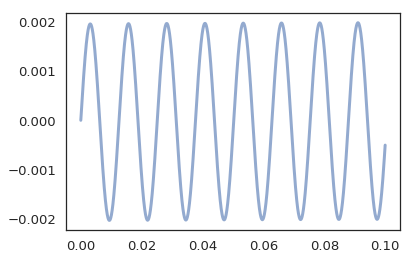

In [181]:
test_sys = make_system(make_params(R=1000, L=0.0047, C=0.0001, F=500))
res = run_odeint(test_sys, slope_func)
#for i in range(len(res)):
#    out.append([i*test_sys.sim_timestep, res['I'][i]])

#out = []
#for i in np.linspace(0, 0.1, 500):
#    out.append([i, np.sin(i*500)])
#out = np.asarray(out)/10
#plot(out, '--')
plot(res['I'][0:0.1]*test_sys.R, '-')

As we can see, the output of this system is (similarly) a sin wave, showing its validity as an analog filter.

### Defining the transfer function of the circuit. 

We found that the differential equations of this circuit required too high of a simulation fidelity to simulate accurately at high frequencies. We decided to transform the time-based differential equations into a frequency-based transfer function, which the python-control library would allow us to manipulate much faster and more accurately than could be done with a differential equation-based simulation.

Generalized transfer function of a series RLC circuit: 

$\frac{V_o}{V_i}=\frac{R}{L} \frac{s}{s^2 + \frac{R}{L} + \frac{1}{LC}}$.

By seperating the coefficients of ω, the equation is more explicitly shown. The "top" and "bottom" in the following section presents the numerator and denominators of the transfer function. 


In [182]:
top = np.asarray([1, 0])*R
bottom = np.asarray([1, R/L, 1/(L*C)])*L
sys_tf = cntrl.tf(top, bottom)


          1000 s
---------------------------
0.0047 s^2 + 1000 s + 1e+04

In [183]:
def make_tf(params):
    R = params.R
    L = params.L
    C = params.C
    top = np.asarray([1, 0])*R
    bottom = np.asarray([1, R/L, 1/(L*C)])*L
    return cntrl.tf(top, bottom)

IV. Defining step functions

In order to simulate the system against an arbitrary time signal, we need to transform it into a state-space representation, in the form

$\frac{d}{dt} x = \mathbf{A}x + \mathbf{B}u$

or, in discrete-time form

$x_{t+1} = \mathbf{A_c}x_t + \mathbf{B_c}u$


In [187]:
def make_ss(sys_tf, dt=None):
    if dt is None:
        return cntrl.ss(sys_tf)
    return cntrl.c2d(cntrl.ss(sys_tf), dt)


In [188]:
sys_tf = make_tf(make_params(R=1000, L=0.0047, C=0.0001, F=1))


          1000 s
---------------------------
0.0047 s^2 + 1000 s + 1e+04

In [418]:
sys_ss_c = make_ss(sys_tf, 0.0001)
print("")

Now, we can write a simple simulation function to test by passing a sine wave at 8 rad/s through the discretized state space model

In [421]:
def lsim(sys, vec):
    state = np.zeros((sys.A.shape[0], 1))
    dt = sys.dt
    t = []
    y = []
    for i in range(len(vec)):
        state = np.matmul(sys.A, state) + sys.B*vec[i]
        output = np.matmul(sys.C, state)
        t.append(i*dt)
        y.append(float(output))
    return t,y
sin_x = np.linspace(0, 8*np.pi, int(1/sys_ss_c.dt))
sin_y = np.sin(sin_x)
t, y = lsim(sys_ss_c, sin_y)
sin_x /= 8*np.pi
print("")

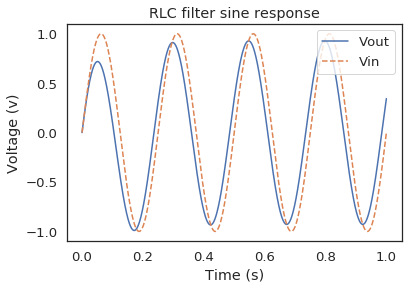

In [325]:
plt.plot(t, y)
plt.plot(sin_x, sin_y, '--')
plt.xlabel("Time (s)")
plt.ylabel("Voltage (v)")
plt.title("RLC filter sine response")
plt.legend(["Vout", "Vin"], loc=1)
plt.show()

To generate a bode (frequency response) plot, we pass in a range of complex numbers representing frequencies, then plot the imaginary part.

In [326]:
#plt.semilogy(np.imag(sys_tf(np.logspace(-3, 3, 1000)*1j)))

def gen_bode(sys_tf, min_exp=-5, max_exp=5, points=1000):
    space = np.logspace(min_exp, max_exp, points)*1j
    data = sys_tf(space)
    out = []
    for i in np.logspace(min_exp, max_exp, points):
        out.append([i, np.imag(sys_tf(i*1j))])
    X = [n[0] for n in out]
    Y = [n[1] for n in out]
    return X, Y

def plot_bode(bode_out):
    X, Y = bode_out
    plt.loglog(X, Y)


As an example, we can plot a filter's response where R=1000, L=0.0047, and C=0.0001

Text(0,0.5,'Gain')

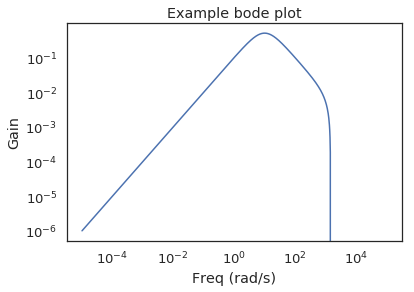

In [327]:
plot_bode(
    gen_bode(
        make_tf(
            make_params(
                R=1000, L=0.0047, C=.0001, F=1
            )
        )
    )
)
plt.title("Example bode plot")
plt.xlabel("Freq (rad/s)")
plt.ylabel("Gain")

To actually analyze the system, we need to know the peak freqency and the frequency range in which the gain is greater than -3dB, equal to $\frac{\sqrt{2}}{2}$

In [328]:
def analyze_bode(plot):
    X, Y = plot
    bw_start = None
    bw_end = None
    peak = X[np.argmax(Y)]
    peak_filt = np.max(Y)
    for i in range(len(Y)-1):
        if (Y[i] > (np.sqrt(2)/2)*peak_filt) and bw_start is None:
            bw_start = X[i]
        if (Y[i] < (np.sqrt(2)/2)*peak_filt) and bw_end is None and bw_start is not None:
            bw_end = X[i]
            
    return peak, bw_end-bw_start


As an example, we'll find the bandpass and bandwidth for the filter represented by the above bode plot

In [329]:

bpass, bwidth = analyze_bode(
        gen_bode(
        make_tf(
            make_params(
                R=1000, L=0.0047, C=0.001, F=1
            )
        )
    )
)
print("Bandpass frequency:",bpass, "rad/s \nBandwidth frequency", bwidth, "rad/s")

Bandpass frequency: 0.9885417021919574 rad/s 
Bandwidth frequency 2.0074322080757216 rad/s


Now, we will sweep a range of values for R, L, and C in order to find the values for our filter to best match our design parameters (passband frequency of 40 rad/s, and a bandwidth of 5 rad/s)

In [390]:
R_range = np.logspace(1, 3, 10)
L_range = np.logspace(-2, 4, 10)
C_range = np.logspace(-3, -2, 10)

permutations = []
for r in R_range:
    for l in L_range:
        for c in C_range:
            permutations.append([r, l, c])

results = []
tick = 0
for i in permutations:
    tick += 1
    print("\r                    ", end='\r')
    print(tick, "of", 10**3, end='\r')
    bandpass, bandwidth = analyze_bode(
        gen_bode(
            make_tf(
                make_params(
                    R=i[0], L=i[1], C=i[2], F=0
                )
            )
        )
    )
    results.append(
        [
            [bandpass, bandwidth], [i[0], i[1], i[2]]
        ]
    )



In [396]:
def error(bandpass, bandwidth, wanted_bandpass=40, wanted_bandwidth=5):
    bandpass_err = abs(wanted_bandpass-bandpass)
    bandwidth_err = abs(wanted_bandwidth-bandwidth)
    return bandpass_err+bandwidth_err

In [437]:
rlc_vs_err = []
for i in results:
    rlc_vs_err.append([error(i[0][0], i[0][1]), i[1][0], i[1][1], i[1][2]])
rlc_vs_err = np.asarray(rlc_vs_err)
err = [n[0] for n in rlc_vs_err]
R = [n[1] for n in rlc_vs_err]
L = [n[2] for n in rlc_vs_err]
C = [n[3] for n in rlc_vs_err]
#for i in rlc_vs_err[0:5]:
#    print(i)
    
#print(np.argmin(err))
print("Minimized error, R, L, and C:", rlc_vs_err[np.argmin(err)])
#for i in sorted(rlc_vs_err, key=lambda x: x[0]):
#    print(i)

Minimized error, R, L, and C: [1.54386162e+01 1.00000000e+01 1.00000000e+00 1.00000000e-03]


Our basic sweeping error minimizer found that R,L,C values of 10Ω, 1H, and 0.001uF respectively, would minimize the response error of the filter.

To use Scipy's nonlinear solver, we need to define an error function to minimize

In [425]:
def err_func(x):
    R, L, C = x
    bandpass, bandwidth = analyze_bode(
        gen_bode(
            make_tf(
                make_params(
                    R=i[0], L=i[1], C=i[2], F=0
                )
            )
        )
    )
    return error(bandpass, bandwidth, wanted_bandwidth = 5, wanted_bandpass=40)
    

9.908228099003788 19.023926412649782
      fun: 42.1545573380097
 hess_inv: array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])
      jac: array([0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 5
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([1.e+02, 1.e-01, 1.e-03])


Text(0,0.5,'Gain')

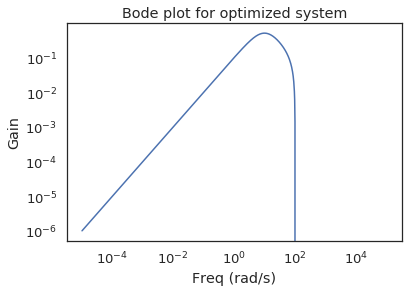

In [426]:


from scipy.optimize import minimize
optim_RLC = minimize(err_func, np.asarray([100, 0.1, 0.001]))
R, L, C = optim_RLC.x
bpass, bwidth = analyze_bode(
        gen_bode(
        make_tf(
            make_params(
                R=R, L=L, C=C, F=1
            )
        )
    )
)
print(bpass, bwidth)
print(optim_RLC)

plot_bode(gen_bode(
        make_tf(
            make_params(
                R=R, L=L, C=C, F=1
            )
        )))
plt.title("Bode plot for optimized system")
plt.xlabel("Freq (rad/s)")
plt.ylabel("Gain")

### Results

Ultimately, we were not able to successfully optimize for the given set of frequency characteristics. While our desired frequency characteristics were a passband of 40 rad/s and a bandwidth of 5 rad/s, the filter we were able to identify that best matched our desired frequency response had a passband of 10 rad/s and a bandwidth of 20 rad/s. 

With more computational runtime and resources, we would be able to run a higher fidelity simulation and try more of Scipy's optimization methods.

### Interpretation

We're not completely sure why neither the brute-force method (sweeping values for R, L, and C) nor the scipy solver was able to successfully optimize the circuit parameters. Given more time, the transfer function could be linearized using the jacobian matrix and we could've written a custom solver. 

In the case of analog AC circuits with complex impedence, we found it's frequently necessary to transform into the frequency domain (the transfer function) in order to minimize computation time among higher frequencies.

We also found that minute changes in the transfer function and the R, L, and C values of the circuit can lead to massively different bandwidth and bandpass values.

In terms of iteration, we moved from initially verifying some of our model assumptions using transfer function representations. However, we wanted to actually model in the time domain using differential equations, so we implemented and integrated them using Scipy's ODE Solver. While successful, we found that the computation time required to sweep values of R, L, and C with the time-domain method was much higher than we could afford, so we were forced to move back to the transfer function-based model.


One assumption we made is that all parts of the circuit behave as ideal discrete components. In the real world, a resistor will have an amount of capacitance, an inductor will have an amount of resistance, a power supply will have voltage drop as current is drawn, etc.

### Final abstract
Overall, we sought to find values of R, L, and C that would give a series RLC filter a bandpass frequency of as close to 40 rad/s as possible, and a bandwidth of as close to 5 rad/s as possible.

While we were not able to minimize error to an acceptable degree, we found that R, L, and C values of 10, 0.1, and 0.001 gave a bandpass frequency of 20 rad/s and a bandwidth of 9.9 rad/s, as shown by the following bode plot:

Text(0,0.5,'Gain')

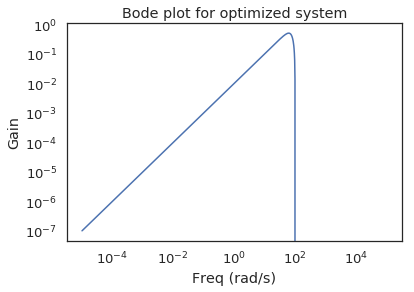

In [430]:
plot_bode(gen_bode(make_tf(make_params(R=10, L=0.1, C=0.001, F=1))))
plt.title("Bode plot for optimized system");plt.xlabel("Freq (rad/s)");plt.ylabel("Gain")